In [8]:
import os
import cv2
import numpy as np
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.color import rgb2gray
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import itertools
import glob
import tensorflow as tf
import requests,io
import pytesseract
print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.16.1


In [9]:
# Перезагрузка папки с фотографиями
tich_file=glob.glob('./Object_Detection/test/*')
print(len(tich_file),tich_file)

6 ['./Object_Detection/test\\111.png', './Object_Detection/test\\my_1.jpg', './Object_Detection/test\\my_2-2.jpg', './Object_Detection/test\\my_4.jpg', './Object_Detection/test\\my_5.jpg', './Object_Detection/test\\my_6.jpg']


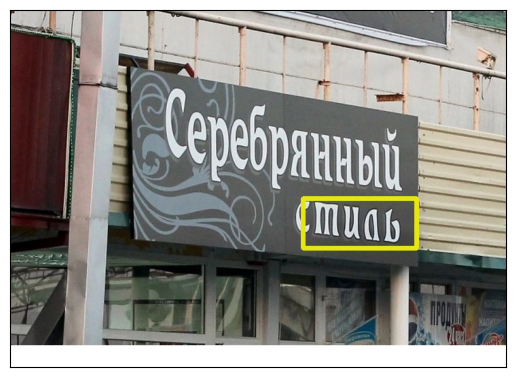

Распознанный номер: 


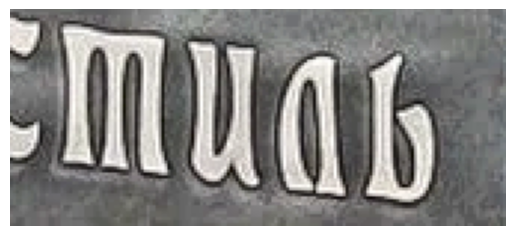

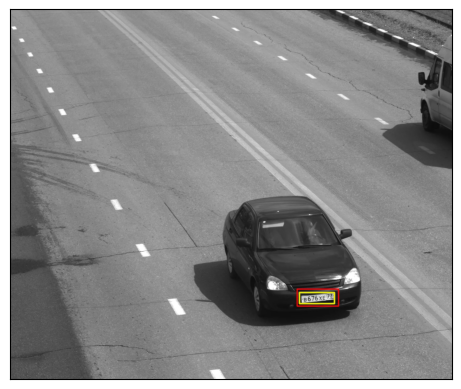

Распознанный номер: ‘B676xE 73,


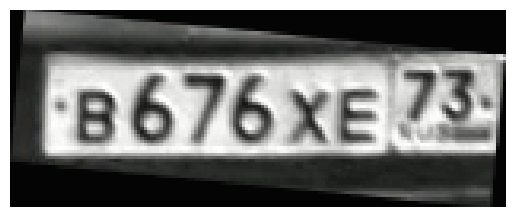

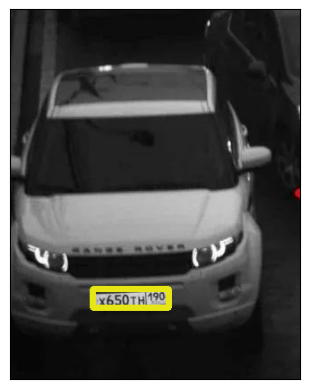

Распознанный номер: 


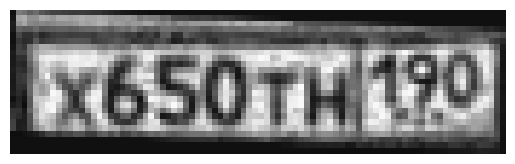

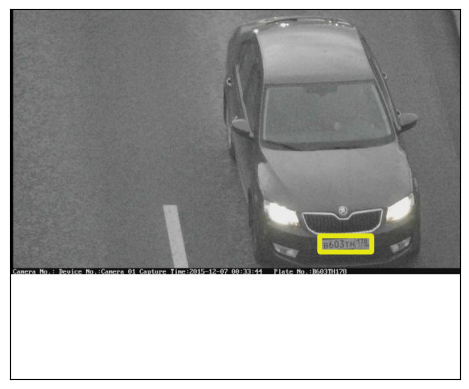

C:\Users\lucky\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lucky\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Распознанный номер: 


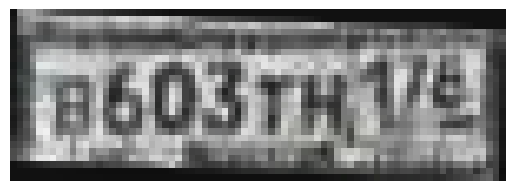

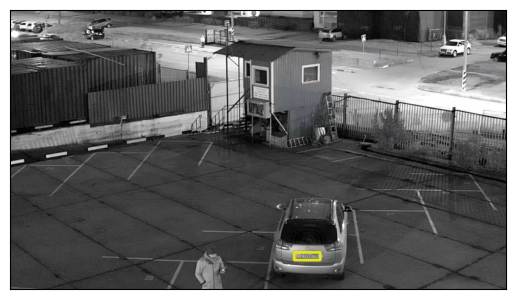

Распознанный номер: Mima;


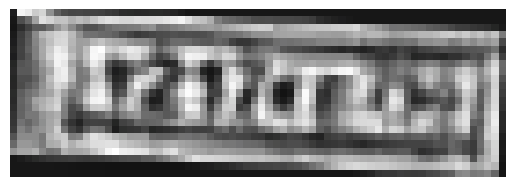

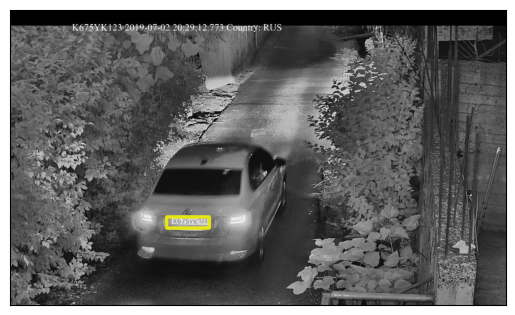

Распознанный номер: Rl K675y« 7123)


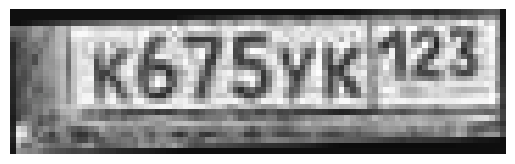

In [10]:
for i in range(len(tich_file)):
    img_name1=tich_file[i]
    path = img_name1   
    image0 = cv2.imread(img_name1, 1)
    image_height, image_width, _ = image0.shape
    image = cv2.resize(image0, (1024,1024))
    image = image.astype(np.float32)
    paths='./model_resnet.tflite'
    interpreter = tf.lite.Interpreter(model_path=paths)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    X_data1=np.float32(image.reshape(1,1024, 1024,3))
    input_index = (interpreter.get_input_details()[0]['index'])
    interpreter.set_tensor(input_details[0]['index'], X_data1)
    interpreter.invoke()
    detection = interpreter.get_tensor(output_details[0]['index'])
    net_out_value2 = interpreter.get_tensor(output_details[1]['index'])
    net_out_value3 = interpreter.get_tensor(output_details[2]['index'])
    net_out_value4 = interpreter.get_tensor(output_details[3]['index'])
    img = image0
    razmer=img.shape

    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other
    img3=img[:,:,:]

    box_x =int( detection[0,0,0] * image_height)
    box_y = int(detection[0,0,1] * image_width)
    box_width =int( detection[0,0,2] * image_height)
    box_height = int(detection[0,0,3] * image_width)
    if  np.min(detection[0,0,:])>=0:
        cv2.rectangle(img2, ( box_y,box_x), (box_height,box_width ), (230, 230, 21), thickness=5)

        plt.imshow(img2)
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        image = img3[box_x:box_width,box_y:box_height,:]
        grayscale = rgb2gray(image)
        edges = canny(grayscale, sigma=3.0)
        out, angles, distances = hough_line(edges)
        _, angles_peaks, _ = hough_line_peaks(out, angles, distances, num_peaks=20)
        angle=np.mean(np.rad2deg(angles_peaks))
        if 0 <= angle <= 90:
            rot_angle = angle - 90
        elif -45 <= angle < 0:
            rot_angle = angle - 90
        elif -90 <= angle < -45:
            rot_angle = 90 + angle
        if abs(rot_angle)>20:
            rot_angle=0
        rotated = rotate(image, rot_angle, resize=True)*255
        rotated =rotated.astype(np.uint8)
        rotated1=rotated[:,:,:]
        minus=np.abs(int(np.sin(np.radians(rot_angle))*rotated.shape[0]))
        if rotated.shape[1]/rotated.shape[0]<2 and minus >10:

            rotated1=rotated[minus:-minus,:,:]
        lab= cv2.cvtColor(rotated1, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        # Если вы на Windows, укажите путь к tesseract.exe (запрос на установку Tesseract OCR):
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        
        # Преобразуем изображение 'final' в формат, подходящий для pytesseract
        # Преобразуем его в оттенки серого
        gray = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
        
        # Применяем пороговое значение для улучшения распознавания (опционально)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
        
        # Используем pytesseract для распознавания текста
        custom_config = r'--oem 3 --psm 6'  # Настройки для Tesseract (можно настроить по необходимости)
        recognized_text = pytesseract.image_to_string(thresh, config=custom_config)
        
        print("Распознанный номер:", recognized_text.strip())
        
        # Отображаем изображение
        plt.imshow(final)
        plt.axis('off')  # Не показывать оси
        plt.show()
    else:
        plt.imshow(image0)
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show() 
        print('нет')